In [232]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve, auc
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

import keras
import tensorflow
from keras.datasets import mnist
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import optimizers

from sklearn.model_selection import KFold, StratifiedKFold

#from preprocessing import preprocess
plt.rcParams["figure.dpi"] = 150

In [221]:
# from collections import Counter
# import requests

# with requests.get(
#     "https://docs.google.com/spreadsheets/d/1wduqo5WyYmCpaGnE81sLNGU0VSodIekMfpmEwU0fGqs/export?format=csv") as r, open("features.csv", "wb") as f:
#     for chunk in r.iter_content():
#         f.write(chunk)

# with requests.get(
#     "https://docs.google.com/spreadsheets/d/1gvZ03uAL6THwd04Y98GtIj6SeAHiKyQY5UisuuyFSUs/export?format=csv") as r, open("target.csv", "wb") as f:
#     for chunk in r.iter_content():
#         f.write(chunk)

In [222]:
df_features = pd.read_csv("features.csv")
df_target = pd.read_csv("target.csv")
df = df_features.merge(df_target, left_on='id', right_on='id')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [223]:
def basic_preprocessing(df: pd.DataFrame, test_size=0.1):
    df['presion_atmosferica_tarde'] = pd.to_numeric(df['presion_atmosferica_tarde'],errors='coerce')    
    df['dia'] = pd.to_datetime(df['dia'])
    df = df.dropna(subset=['llovieron_hamburguesas_al_dia_siguiente']) 
    df = df.dropna(subset=['llovieron_hamburguesas_hoy'])
    df = df.drop(columns = ['id'])
    df['mes'] = df['dia'].dt.month
    df = df.drop(columns = ['dia']) 
    df = df[df.isnull().mean(1) < 0.4]
    
    label_encoder = preprocessing.LabelEncoder()
    
    label_encoder.fit(df['llovieron_hamburguesas_hoy'])
    df['llovieron_hamburguesas_hoy'] = label_encoder.transform(df['llovieron_hamburguesas_hoy'])

    label_encoder.fit(df['llovieron_hamburguesas_al_dia_siguiente'])
    df['llovieron_hamburguesas_al_dia_siguiente'] = label_encoder.transform(df['llovieron_hamburguesas_al_dia_siguiente'])
    
    
    X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
    y = df['llovieron_hamburguesas_al_dia_siguiente']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=test_size, stratify=y.astype(str))
    
    numerical_features = ['horas_de_sol', 'nubosidad_tarde', 'nubosidad_temprano', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde',
                       'rafaga_viento_max_velocidad', 'humedad_tarde', 'temperatura_tarde', 'mm_lluvia_dia',
                       'velocidad_viendo_tarde', 'humedad_temprano', 'velocidad_viendo_temprano', 'temperatura_temprano',
                       'temp_min', 'temp_max', 'mm_evaporados_agua']
    
    for feature in numerical_features:
        if feature == 'mm_lluvia_dia' or feature == 'mm_evaporados_agua':
            X_train[feature] = X_train[feature].fillna(X_train[feature].median())
            X_test[feature] = X_test[feature].fillna(X_test[feature].median())
        else:
            X_train[feature] = X_train[feature].fillna(X_train[feature].mean())
            X_test[feature] = X_test[feature].fillna(X_test[feature].mean())
            
    
    return X_train, X_test, y_train, y_test

In [224]:
def preprocessing1(df: pd.DataFrame):
    X_train, X_test, y_train, y_test = basic_preprocessing(df)

    X_train = pd.get_dummies(X_train, drop_first=True, dummy_na=True, columns=['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde', 'barrio'])
    X_test = pd.get_dummies(X_test, drop_first=True, dummy_na=True, columns=['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde', 'barrio'])

    features = ['horas_de_sol', 'nubosidad_tarde', 'nubosidad_temprano', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 'rafaga_viento_max_velocidad',
                                        'humedad_tarde', 'temperatura_tarde', 'mm_lluvia_dia', 'velocidad_viendo_tarde', 'humedad_temprano',
                                        'temp_min', 'temp_max', 'velocidad_viendo_temprano', 'temperatura_temprano', 'mm_evaporados_agua']
    
    scaler = preprocessing.StandardScaler()

    X_train[features] = scaler.fit_transform(X_train[features])
    X_test[features] = scaler.fit_transform(X_test[features])
        
    return X_train, X_test, y_train, y_test

In [293]:
def preprocessing2(df: pd.DataFrame):
    X_train, X_test, y_train, y_test = basic_preprocessing(df)

    X_train = X_train.drop(columns = ['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde', 'mes', 'barrio', 'llovieron_hamburguesas_hoy', 'velocidad_viendo_temprano', 'temperatura_temprano', 'mm_evaporados_agua'])  
    X_test = X_test.drop(columns = ['direccion_viento_temprano', 'rafaga_viento_max_direccion', 'direccion_viento_tarde', 'mes', 'barrio', 'llovieron_hamburguesas_hoy', 'velocidad_viendo_temprano', 'temperatura_temprano', 'mm_evaporados_agua'])  
    
    features = ['horas_de_sol', 'nubosidad_tarde', 'nubosidad_temprano', 'presion_atmosferica_temprano', 'presion_atmosferica_tarde', 'rafaga_viento_max_velocidad',
                                        'humedad_tarde', 'temperatura_tarde', 'mm_lluvia_dia', 'velocidad_viendo_tarde', 'humedad_temprano',
                                        'temp_min', 'temp_max']
    
    scaler = preprocessing.StandardScaler()

    X_train[features] = scaler.fit_transform(X_train[features])
    X_test[features] = scaler.fit_transform(X_test[features])
        
    return X_train, X_test, y_train, y_test

In [225]:
def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(figsize=(15, 10))
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})'
    )
    plt.scatter(_fpr, x)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()



In [ ]:
X_train1, X_test1, y_train1, y_test1 = preprocessing1(df)

a, b, c, d = preprocessing2(df)
#X_train1, X_validation1, y_train1, y_validation1 = train_test_split(X_train1, y_train1, random_state=117, test_size=0.3, stratify=y_train1)

In [296]:
X_train, X_test, y_train, y_test = preprocessing2(df)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=117, test_size=0.3, stratify=y_train)


In [312]:
model1 = Sequential()
model1.add(Dense(13, input_dim=13, activation='tanh'))
model1.add(Dense(26, input_dim=13, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=0.0001))

In [313]:
history1 = model1.fit(X_train.values, y_train, epochs=300, verbose=2, validation_data=(X_validation.values, y_validation))


Epoch 1/300
2189/2189 - 4s - loss: 0.6266 - val_loss: 0.6027 - 4s/epoch - 2ms/step
Epoch 2/300
2189/2189 - 4s - loss: 0.5852 - val_loss: 0.5671 - 4s/epoch - 2ms/step
Epoch 3/300
2189/2189 - 4s - loss: 0.5541 - val_loss: 0.5401 - 4s/epoch - 2ms/step
Epoch 4/300
2189/2189 - 3s - loss: 0.5303 - val_loss: 0.5192 - 3s/epoch - 2ms/step
Epoch 5/300
2189/2189 - 3s - loss: 0.5116 - val_loss: 0.5026 - 3s/epoch - 2ms/step
Epoch 6/300
2189/2189 - 3s - loss: 0.4967 - val_loss: 0.4892 - 3s/epoch - 1ms/step
Epoch 7/300
2189/2189 - 3s - loss: 0.4846 - val_loss: 0.4781 - 3s/epoch - 2ms/step
Epoch 8/300
2189/2189 - 3s - loss: 0.4745 - val_loss: 0.4689 - 3s/epoch - 1ms/step
Epoch 9/300
2189/2189 - 5s - loss: 0.4660 - val_loss: 0.4610 - 5s/epoch - 2ms/step
Epoch 10/300
2189/2189 - 4s - loss: 0.4587 - val_loss: 0.4541 - 4s/epoch - 2ms/step
Epoch 11/300
2189/2189 - 3s - loss: 0.4524 - val_loss: 0.4481 - 3s/epoch - 1ms/step
Epoch 12/300
2189/2189 - 3s - loss: 0.4468 - val_loss: 0.4428 - 3s/epoch - 1ms/step
E

In [314]:
y_pred1 = model1.predict(X_test)

print(f"Auc Roc: {roc_auc_score(y_test, y_pred1)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred1.round())}")
print(f"Precision: {precision_score(y_test, y_pred1.round())}")
print(f"Recall: {recall_score(y_test, y_pred1.round())}")

Auc Roc: 0.8661150694804977
Accuracy: 0.8424177010253643
Precision: 0.7004002287021155
Recall: 0.4993885038728088


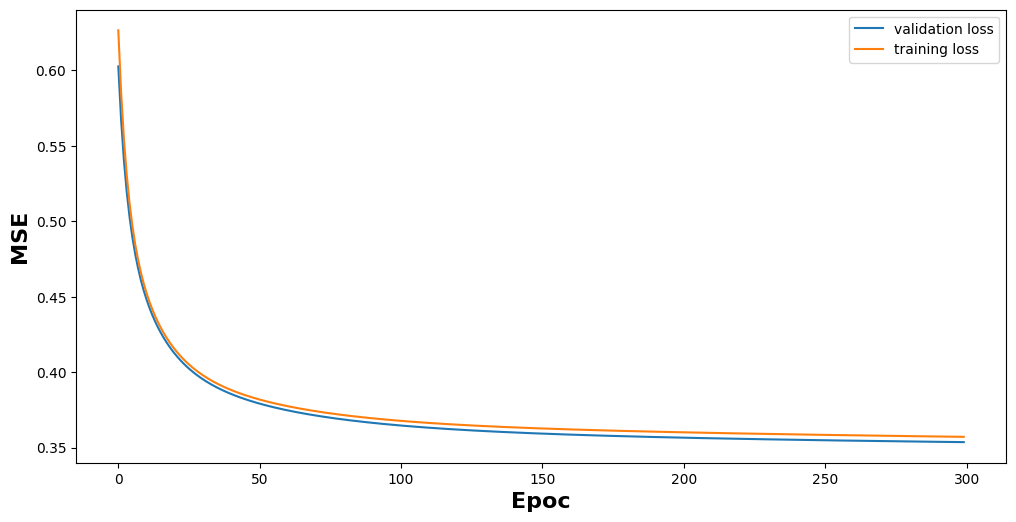

In [315]:
fig = plt.figure(figsize=(12, 6), dpi=100)
plt.plot(history1.history["val_loss"], label="validation loss")
plt.plot(history1.history["loss"], label="training loss")
plt.xlabel("Epoc", weight="bold", fontsize=16)
plt.ylabel("MSE", weight="bold", fontsize=16)
plt.legend()

In [316]:
X_train, X_test, y_train, y_test = preprocessing1(df)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=117, test_size=0.3, stratify=y_train)

model2 = Sequential()
model2.add(Dense(112, input_dim=112, activation='relu'))
model2.add(Dense(56, input_dim =112, activation='relu'))

model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(learning_rate=0.0001))

In [317]:
history2 = model2.fit(X_train.values, y_train, epochs=100, verbose=2, validation_data=(X_validation.values, y_validation))


Epoch 1/100
2189/2189 - 4s - loss: 0.5732 - val_loss: 0.5396 - 4s/epoch - 2ms/step
Epoch 2/100
2189/2189 - 4s - loss: 0.5207 - val_loss: 0.5053 - 4s/epoch - 2ms/step
Epoch 3/100
2189/2189 - 4s - loss: 0.4910 - val_loss: 0.4794 - 4s/epoch - 2ms/step
Epoch 4/100
2189/2189 - 4s - loss: 0.4684 - val_loss: 0.4597 - 4s/epoch - 2ms/step
Epoch 5/100
2189/2189 - 4s - loss: 0.4512 - val_loss: 0.4445 - 4s/epoch - 2ms/step
Epoch 6/100
2189/2189 - 4s - loss: 0.4378 - val_loss: 0.4325 - 4s/epoch - 2ms/step
Epoch 7/100
2189/2189 - 4s - loss: 0.4272 - val_loss: 0.4230 - 4s/epoch - 2ms/step
Epoch 8/100
2189/2189 - 4s - loss: 0.4188 - val_loss: 0.4154 - 4s/epoch - 2ms/step
Epoch 9/100
2189/2189 - 4s - loss: 0.4120 - val_loss: 0.4091 - 4s/epoch - 2ms/step
Epoch 10/100
2189/2189 - 4s - loss: 0.4064 - val_loss: 0.4040 - 4s/epoch - 2ms/step
Epoch 11/100
2189/2189 - 4s - loss: 0.4018 - val_loss: 0.3996 - 4s/epoch - 2ms/step
Epoch 12/100
2189/2189 - 4s - loss: 0.3978 - val_loss: 0.3959 - 4s/epoch - 2ms/step
E

In [318]:
y_pred2 = model2.predict(X_test)

print(f"Auc Roc: {roc_auc_score(y_test, y_pred2)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred2.round())}")
print(f"Precision: {precision_score(y_test, y_pred2.round())}")
print(f"Recall: {recall_score(y_test, y_pred2.round())}")

Auc Roc: 0.8662868153248763
Accuracy: 0.8459255261737723
Precision: 0.7220888355342137
Recall: 0.49041989400733793


In [247]:
X_train, X_test, y_train, y_test = preprocessing1(df)

skf = StratifiedKFold(n_splits=3)

test_scores = []
for fold_idx, (train_index, test_index) in enumerate(skf.split(X_train.values, y_train.values)):
    
    model = Sequential()
    model.add(Dense(112, input_dim=112, activation='relu'))
    model.add(Dense(56, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='SGD')

    model.fit(X_train.values[train_index], y_train.values[train_index], epochs=100, verbose=2, validation_data=(X_train.values[test_index], y_train.values[test_index]))

    test_score = roc_auc_score(y_train.values[test_index], model.predict(X_train.values[test_index]))
    print(f"fold {fold_idx}: roc_auc_score is {test_score:.4f}")
    test_scores.append(test_score)
print(f"mean test roc_auc_score is: {np.mean(test_scores):.4f}")
test_scores

Epoch 1/100
2085/2085 - 4s - loss: 0.3834 - val_loss: 0.3564 - 4s/epoch - 2ms/step
Epoch 2/100
2085/2085 - 3s - loss: 0.3544 - val_loss: 0.3509 - 3s/epoch - 2ms/step
Epoch 3/100
2085/2085 - 3s - loss: 0.3480 - val_loss: 0.3486 - 3s/epoch - 2ms/step
Epoch 4/100
2085/2085 - 3s - loss: 0.3447 - val_loss: 0.3432 - 3s/epoch - 2ms/step
Epoch 5/100
2085/2085 - 3s - loss: 0.3409 - val_loss: 0.3409 - 3s/epoch - 2ms/step
Epoch 6/100
2085/2085 - 3s - loss: 0.3392 - val_loss: 0.3503 - 3s/epoch - 2ms/step
Epoch 7/100
2085/2085 - 5s - loss: 0.3371 - val_loss: 0.3381 - 5s/epoch - 3ms/step
Epoch 8/100
2085/2085 - 5s - loss: 0.3357 - val_loss: 0.3358 - 5s/epoch - 2ms/step
Epoch 9/100
2085/2085 - 4s - loss: 0.3339 - val_loss: 0.3344 - 4s/epoch - 2ms/step
Epoch 10/100
2085/2085 - 4s - loss: 0.3331 - val_loss: 0.3343 - 4s/epoch - 2ms/step
Epoch 11/100
2085/2085 - 5s - loss: 0.3315 - val_loss: 0.3350 - 5s/epoch - 2ms/step
Epoch 12/100
2085/2085 - 3s - loss: 0.3303 - val_loss: 0.3380 - 3s/epoch - 2ms/step
E

KeyboardInterrupt: 

In [ ]:
X_train, X_test, y_train, y_test = preprocessing1(df)

skf = StratifiedKFold(n_splits=3)

test_scores = []
for fold_idx, (train_index, test_index) in enumerate(skf.split(X_train.values, y_train.values)):
    
    model = Sequential()
    model.add(Dense(112, input_dim=112, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(56, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam())

    model.fit(X_train.values[train_index], y_train.values[train_index], epochs=100, verbose=2, validation_data=(X_train.values[test_index], y_train.values[test_index]))

    test_score = roc_auc_score(y_train.values[test_index], model.predict(X_train.values[test_index]))
    print(f"fold {fold_idx}: roc_auc_score is {test_score:.4f}")
    test_scores.append(test_score)
print(f"mean test roc_auc_score is: {np.mean(test_scores):.4f}")
test_scores